In [1]:
import autograd.numpy as np       # wrapped numpy
import matplotlib.pyplot as plt
import GPy 

from autograd import grad, jacobian
from autograd import elementwise_grad as egrad

In [2]:
# http://videolectures.net/deeplearning2017_johnson_automatic_differentiation/

# Gradient / Jacobian of a function

In [3]:
def f1(x):
    return(np.array([x[0]**2, x[1]]))

In [4]:
f1(np.array([2, 3]))

array([4, 3])

In [5]:
Jf1 = jacobian(f1)

In [6]:
x = np.array([1., 1.])
Jf1(x)

array([[2., 0.],
       [0., 1.]])

### Partial derivatives autograd:

In [7]:
def fs(x, y):
    z = x**2 + y
    return(z)

In [8]:
fs_x = egrad(fs, 0)
fs_y = egrad(fs, 1)

In [9]:
print('fs_x =',  fs_x(1., 1.), 'fs_y =', fs_y(1., 1.))

fs_x = 2.0 fs_y = 1.0


In [10]:
x = np.array([1., 1.])
y = np.array([1., 1.])

fs_x(x , y)

array([2., 2.])

## First Idea: 

use .K method for kernel objects and perform elementwise autodiff.

Let $k : \mathbb{R}^n \times \mathbb{R}^n \longrightarrow \mathbb{R}$. 

$$
\begin{align*}
\partial_{x_1} kern.K(x, y) &= \partial_{x_1} kern.K\left([x1, ..., x_n], \ [y_1, ..., y_n]\right) \\
                        &= \nabla_x kern.K_y(x)[0]
\end{align*}
$$

where $kern.K_y(x) := kern.K(x, y)$.


In [11]:
def Kmat(x, y):
    '''
    wrapper for .K method of GPy
    '''
    krbf2d = GPy.kern.RBF(2, lengthscale = 0.25)
    K = krbf2d.K(x, y)
    return(K)

In [12]:
npts = 2
x = np.linspace(-1.2, 1.2, npts)
X = []

for i in range(npts):
    for j in range(npts):
        X.append([x[i], x[j]])
        
X = np.array(X)

In [13]:
krbf2d = GPy.kern.RBF(2, lengthscale = 0.25)
Krbf2d = krbf2d.K(X, X)

In [14]:
x = np.array([1., 1.])
x = x[None, :]

Kmat(x, x)

array([[1.]])

In [15]:
# Problems wrapping code around GPy
Kmat_x = grad(Kmat, 0)
Kmat_x(x, x)

AttributeError: 'ArrayBox' object has no attribute 'sqrt'

# Use autodiff on user-defined kerneks

Given $k : \mathbb{R}^n \times \mathbb{R}^n \longrightarrow \mathbb{R}$, use autodiff to get

$$
\nabla_x k_y := \partial_x k : \mathbb{R}^n \times \mathbb{R}^n \longrightarrow \mathbb{R}
$$ 

Then, build covariance matrix of $\mathcal{F}f$.

Autograd computes the appropriate notion of gradient for each of the inputs:

In [16]:
def fp(x, y, l, s):
    k = np.sum(l*x - s*y)
    return (k)

In [17]:
x = np.array([1., 1.])
y = np.array([2., 3.])
l = 2.
s = 1.

fp_x = grad(fp, 0)
fp_y = grad(fp, 1)
fp_l = grad(fp, 2)
fp_s = grad(fp, 3)

print('fp_x = ', fp_x(x, y, l, s), ', fp_y = ', fp_y(x, y, l, s), 
      ', fp_l = ', fp_l(x, y, l, s), ', fp_s = ', fp_s(x, y, l, s))


fp_x =  [2. 2.] , fp_y =  [-1. -1.] , fp_l =  2.0 , fp_s =  -5.0


A change in the dimension of the inputs changes the dimension of the gradient:

In [18]:
x = 1.
y = 2.

l = 2.
s = 1.

print('fp_x = ', fp_x(x, y, l, s), ', fp_y = ', fp_y(x, y, l, s), 
      ', fp_l = ', fp_l(x, y, l, s), ', fp_s = ', fp_s(x, y, l, s))

fp_x =  2.0 , fp_y =  -1.0 , fp_l =  1.0 , fp_s =  -2.0


# div-free Gaussian Process:

In [19]:
def RBF(x, y, l, s):

    d = np.sum((x - y) ** 2)
    k = np.exp(-d / l**2) / s**2
    
    return (k)

In [20]:
x = 2.
y = 3.
l = 2.
s = 1.

RBF_x = grad(RBF, 0)
RBF_y = grad(RBF, 1)
RBF_l = grad(RBF, 2)
RBF_s = grad(RBF, 3)

print('RBF_x = ', RBF_x(x, y, l, s), ', RBF_y = ', RBF_y(x, y, l, s), 
      ', RBF_l = ', RBF_l(x, y, l, s), ', RBF_s = ', RBF_s(x, y, l, s))

RBF_x =  0.38940039153570244 , RBF_y =  -0.38940039153570244 , RBF_l =  0.19470019576785122 , RBF_s =  -1.5576015661428098


### A Gaussian Process and its derivative

$f \sim GP(0, k)$, then $f' \sim GP(0, k')$ where:

$$
k'(x, y) = \partial_{xy}^2k(x, y)
$$

In [189]:
RBFxy = grad(grad(RBF, 0), 1) # \partial_{xy}^2 k(x, y)

In [190]:
x = np.arange(-2., 2., 0.025)
y = np.arange(-2., 2., 0.025)
l = 0.5
s = 1

npts = np.shape(x)[0]

In [191]:
def Kmat(x, y, kern, l, s):
    
    npts = np.shape(x)[0]
    K = np.zeros((npts, npts))
    for i, a in enumerate(x):
        for j, b in enumerate(y):
            K[i, j] = kern(a, b, l, s)
            
    return(K)

In [192]:
K = Kmat(x, y, RBF, l, s)
Kxy = Kmat(x, y, RBFxy, l, s)

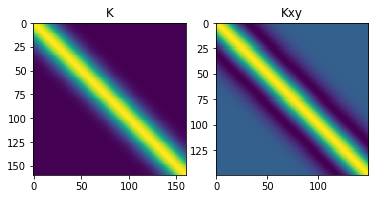

In [193]:
f, ax = plt.subplots(1,2)
ax[0].imshow(K)
ax[1].imshow(Kx)
ax[0].title.set_text('K')
ax[1].title.set_text('Kxy')

In [194]:
nsamples = 2
mu = np.zeros((npts)) 

Z = np.random.multivariate_normal(mu, K, nsamples)
Zx = np.random.multivariate_normal(mu, Kxy, nsamples)

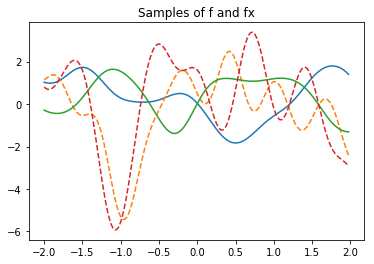

In [195]:
for i in range(nsamples):
    plt.plot(x[:], Z[i,:])
    plt.plot(x[:], Zx[i,:], '--')
    
plt.title('Samples of f and fx')
plt.show()

## Div-free kernels

Consider a vector valued Gaussian Process $f : \mathbb{R}^2 \longrightarrow \mathbb{R}^2$ with independent coordinates.

To build a divergence free GP, just find an operator $\mathcal{F}$ such that $div \mathcal{F} = 0$ and use $g = \mathcal{F} f$. The process $g$ has the kernel:

$$ k(x, y) =
\begin{bmatrix}
\partial_{x_2 y_2} k_1(x, y) & \partial_{x_2 y_1} k_2(x, y) \\
\partial_{x_1 y_2} k_1(x, y) & \partial_{x_1 y_1} k_2(x, y) 
\end{bmatrix}
$$

In [203]:
def Matern32(x, y, l, s):
    
    srt3 = np.sqrt(3)
    d = np.sum(np.abs(x - y))
    
    k = (1 + (srt3 * d) / l) * np.exp(-srt3*d / l) / s**2
    
    return (k)


def Matern52(x, y, l, s):
    
    srt5 = np.sqrt(5)
    d = np.sum(np.abs(x - y))
    t = (srt5 * d) / l
    k = (1 + t + (t**2) / 3) * np.exp(-srt5*d / l) / s**2
    
    return (k)

In [204]:
KRBF = Kmat(x, y, RBF, l, s)
Km32 = Kmat(x, y, Matern32, l, s)
Km52 = Kmat(x, y, Matern52, l, s)

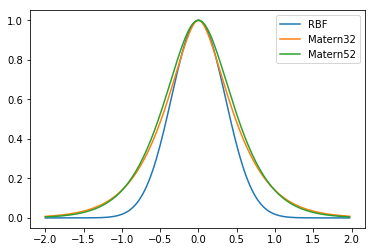

In [205]:
plt.plot(x, KRBF[80, :], label = 'RBF')
plt.plot(x, Km32[80, :], label = 'Matern32')
plt.plot(x, Km52[80, :], label = 'Matern52')
plt.legend()
plt.show()

In [211]:
Matern32_xy = jacobian(grad(Matern32))
GradMatern32 = grad(Matern32)

In [212]:
x = np.array([1., 1.])
y = np.array([2., 3.])
l = 2.
s = 1.

Matern32_xy(x, y, l, s)
GradMatern32(x, y, l, s)

array([0.16743736, 0.16743736])

In [182]:
x = np.array([1., 1.])
y = np.array([2., 3.])
l = 2.
s = 1.

Matern32_x = grad(Matern32, 0)
Matern32_y = grad(Matern32, 1)
Matern32_l = grad(Matern32, 2)
Matern32_s = grad(Matern32, 3)

print('Matern32_x = ', Matern32_x(x, y, l, s), ', Matern32_y = ', Matern32_y(x, y, l, s), 
      ', Matern32_l = ', Matern32_l(x, y, l, s), ', Matern32_s = ', Matern32_s(x, y, l, s))

Matern32_x =  [0.16743736 0.16743736] , Matern32_y =  [-0.16743736 -0.16743736] , Matern32_l =  0.25115603313679896 , Matern32_s =  -0.5355132137288187
